<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Neural-style-transfer" data-toc-modified-id="Neural-style-transfer-1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Neural style transfer</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span><ul class="toc-item"><li><span><a href="#Importing-everything" data-toc-modified-id="Importing-everything-1.1.1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Importing everything</a></span></li><li><span><a href="#Show-initial-images" data-toc-modified-id="Show-initial-images-1.1.2" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Show initial images</a></span></li><li><span><a href="#Deprocess-image" data-toc-modified-id="Deprocess-image-1.1.3" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1.3&nbsp;&nbsp;</span>Deprocess image</a></span></li><li><span><a href="#Taking-out-layers-for-transfer-learning" data-toc-modified-id="Taking-out-layers-for-transfer-learning-1.1.4" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1.4&nbsp;&nbsp;</span>Taking out layers for transfer learning</a></span></li><li><span><a href="#Content-Loss" data-toc-modified-id="Content-Loss-1.1.5" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1.5&nbsp;&nbsp;</span>Content Loss</a></span></li><li><span><a href="#Style-loss" data-toc-modified-id="Style-loss-1.1.6" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.1.6&nbsp;&nbsp;</span>Style loss</a></span></li></ul></li><li><span><a href="#Model" data-toc-modified-id="Model-1.2" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Model</a></span><ul class="toc-item"><li><span><a href="#Gradient-descent" data-toc-modified-id="Gradient-descent-1.2.1" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Gradient descent</a></span></li><li><span><a href="#style-transfer-iteration" data-toc-modified-id="style-transfer-iteration-1.2.2" data-vivaldi-spatnav-clickable="1"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>style transfer iteration</a></span></li></ul></li></ul></li></ul></div>

# Neural style transfer

Code inspired from https://colab.research.google.com/github/MarkDaoust/models/blob/nst_fixes/research/nst_blogpost/4_Neural_Style_Transfer_with_Eager_Execution.ipynb#scrollTo=aDyGj8DmXCJI

## Imports

### Importing everything

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10, 10)
mpl.rcParams['axes.grid'] = False

import numpy as np
from PIL import Image
import time
import tensorflow as tf
import tensorflow.contrib.eager as tfe

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K
tf.enable_eager_execution()

### Show initial images

In [2]:
content_path = 'images/buildings.jpg'
style_path = 'images/stars.jpg'

In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = Image.open(path_to_img)
    long = max(img.size)
    scale = max_dim / long
    img = img.resize((round(img.size[0] * scale), round(img.size[1] * scale)),
                     Image.ANTIALIAS)

    img = kp_image.img_to_array(img)

    img = np.expand_dims(img, axis=0)
    return img

In [4]:
def imshow(img, title=None):

    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

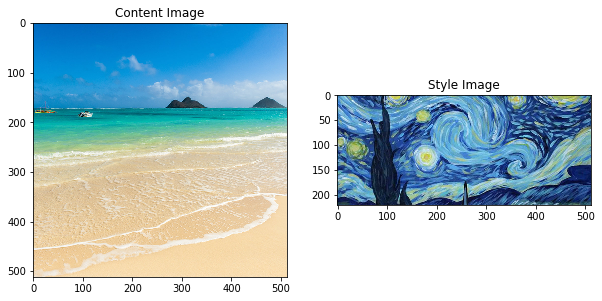

In [5]:
plt.figure(figsize=(10, 10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [6]:
def load_and_process_img(path_to_img):
    img = load_img(path_to_img)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

### Deprocess image
- Show image after de processing 
-VGG networks are trained on image with each channel normalized by mean = [103.939, 116.779, 123.68]and with channels BGR.

In [7]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, (
        "Input to deprocess image must be an image of "
        "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid")

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

### Taking out layers for transfer learning

In [8]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [9]:
def get_model():

    vgg = tf.keras.applications.vgg19.VGG19(
        include_top=False, weights='imagenet')
    vgg.trainable = False

    style_outputs = [vgg.get_layer(name).output for name in style_layers]
    content_outputs = [vgg.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return models.Model(vgg.input, model_outputs)

### Content Loss
- distance of content from output
- over all distances for every layer

- Then we describe the content distance (loss) formally as:

Let  𝐶𝑛𝑛  be a pre-trained deep convolutional neural network. 

Let $X$ be any image, then $C_{nn}(X)$ is the network fed by X. Let $F^l_{ij}(x) \in C_{nn}(x)$ and $P^l_{ij}(p) \in C_{nn}(p)$ describe the respective intermediate feature representation of the network with inputs $x$ and $p$ at layer $l$. Then we describe the content distance (loss) formally as: $$L^l_{content}(p, x) = \sum_{i, j} (F^l_{ij}(x) - P^l_{ij}(p))^2$$


In [10]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

### Style loss
- Gram matrices are computed
- Distance between them is found

- Gram matrix  𝐺𝑙 , where  𝐺𝑙𝑖𝑗  is the inner product between the vectorized feature map  𝑖  and  𝑗  in layer  𝑙 . We can see that  𝐺𝑙𝑖𝑗  generated over the feature map for a given image represents the correlation between feature maps  𝑖  and  𝑗 .
- Contrib of each layer
$$E_l = \frac{1}{4N_l^2M_l^2} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2$$

- Total style loss 
where $G^l_{ij}$ and $A^l_{ij}$ are the respective style representation in layer $l$ of $x$ and $a$. $N_l$ describes the number of feature maps, each of size $M_l = height * width$. Thus, the total style loss across each layer is 
$$L_{style}(a, x) = \sum_{l \in L} w_l E_l$$
where we weight the contribution of each layer's loss by some factor $w_l$. In our case, we weight each layer equally ($w_l =\frac{1}{|L|}$)

In [11]:
def gram_matrix(input_tensor):

    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)


def get_style_loss(base_style, gram_target):

    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)

    return tf.reduce_mean(tf.square(gram_style - gram_target))

In [12]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    style_outputs = model(style_image)
    content_outputs = model(content_image)

    style_features = [
        style_layer[0] for style_layer in style_outputs[:num_style_layers]
    ]
    content_features = [
        content_layer[0]
        for content_layer in content_outputs[num_style_layers:]
    ]
    return style_features, content_features

In [13]:
def compute_loss(model, loss_weights, init_image, gram_style_features,
                 content_features):
    style_weight, content_weight = loss_weights
    model_outputs = model(init_image)

    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]

    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features,
                                        style_output_features):
        style_score += weight_per_style_layer * get_style_loss(
            comb_style[0], target_style)

    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features,
                                            content_output_features):
        content_score += weight_per_content_layer * get_content_loss(
            comb_content[0], target_content)

    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score
    return loss, style_score, content_score

## Model

### Gradient descent 
- Adam 

In [14]:
def compute_grads(cfg):
    with tf.GradientTape() as tape:
        all_loss = compute_loss(**cfg)
    # Compute gradients wrt input image
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

### style transfer iteration

In [15]:
import IPython.display


def run_style_transfer(content_path,
                       style_path,
                       num_iterations=300,
                       content_weight=1e3,
                       style_weight=1e-2):

    model = get_model()
    for layer in model.layers:
        layer.trainable = False

    style_features, content_features = get_feature_representations(
        model, content_path, style_path)
    gram_style_features = [
        gram_matrix(style_feature) for style_feature in style_features
    ]

    init_image = load_and_process_img(content_path)
    init_image = tfe.Variable(init_image, dtype=tf.float32)

    opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

    iter_count = 1

    best_loss, best_img = float('inf'), None

    loss_weights = (style_weight, content_weight)
    cfg = {
        'model': model,
        'loss_weights': loss_weights,
        'init_image': init_image,
        'gram_style_features': gram_style_features,
        'content_features': content_features
    }

    num_rows = 2
    num_cols = 5
    display_interval = num_iterations / (num_rows * num_cols)
    start_time = time.time()
    global_start = time.time()

    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means

    imgs = []
    for i in range(num_iterations):
        print('Iteration: {}'.format(i))
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time()

        if loss < best_loss:

            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval == 0:
            start_time = time.time()

            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))
            print('Total loss: {:.4e}, '
                  'style loss: {:.4e}, '
                  'content loss: {:.4e}, '
                  'time: {:.4f}s'.format(loss, style_score, content_score,
                                         time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14, 4))
    for i, img in enumerate(imgs):
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])

    return best_img, best_loss

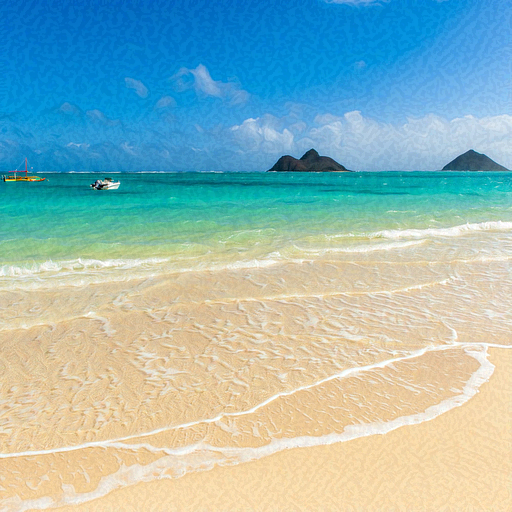

Iteration: 0
Total loss: 5.6334e+08, style loss: 5.6334e+08, content loss: 0.0000e+00, time: 0.1859s
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 6

KeyboardInterrupt: 

In [16]:
best, best_loss = run_style_transfer(
    content_path, style_path, num_iterations=1000)

In [ ]:
Image.fromarray(best)

In [ ]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path)
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final:
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

In [ ]:
show_results(best, content_path, style_path)